In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import itertools

msun_kg = 1.989e+30
pc_m = 3.086e+16
myr_s = 3.154e+13
yr_s = 3.154e+7
au_m = 1.496e+11
au_kpc = 4.84814e-9
m_kpc = 3.24078e-20


/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <

# TWO BODY

In [6]:
def two_body_initial_conditions(m1, m2, a, e=0.0, G=6.67430e-11):
    """
    Generates initial conditions for two bodies in an orbit with physical units.
    
    Parameters:
    m1, m2 : float
        Masses of the two bodies in kg.
    a : float
        Semi-major axis of the relative orbit in meters.
    e : float, optional
        Eccentricity of the orbit (default is 0 for circular orbit).
    G : float, optional
        Gravitational constant in m^3 kg^-1 s^-2 (default is physical value).
    
    Returns:
    dict :
        Dictionary containing initial positions (m) and velocities (m/s).
    """
    
    mu = G * (m1 + m2)  # Standard gravitational parameter
    if e < 1:
        r0 = a * (1 - e)  # Initial separation (periapsis)
        v0 = np.sqrt(mu * (1 + e) / (a * (1 - e)))  # Elliptical or circular
    elif e == 1:  # Parabolic trajectory
        r0 = 2 * a  # Parabolic periapsis
        v0 = np.sqrt(2 * mu / r0)
    else:
        r0 = -a * (e - 1)  # For hyperbolic trajectory, a is negative
        v0 = np.sqrt(mu * (1 + e) / (-a * (1 - e)))  # Hyperbolic trajectory

    
    # Compute center of mass
    r1 = m2 / (m1 + m2) * r0
    r2 = -m1 / (m1 + m2) * r0
    v1 = -m2 / (m1 + m2) * v0
    v2 = m1 / (m1 + m2) * v0
    
    return {
        "r1": np.array([r1, 0.0]),
        "r2": np.array([r2, 0.0]),
        "v1": np.array([0.0, v1]),
        "v2": np.array([0.0, v2])
    }

def two_body_dynamics(t, y, m1, m2, G=6.67430e-11):
    """Defines the equations of motion for the two-body problem with physical units."""
    r1, r2, v1, v2 = y[:2], y[2:4], y[4:6], y[6:]
    r12 = np.linalg.norm(r1 - r2)
    
    a1 = -G * m2 * (r1 - r2) / r12**3
    a2 = -G * m1 * (r2 - r1) / r12**3
    
    return np.concatenate([v1, v2, a1, a2])

def simulate_two_body(m1, m2, a, e=0.0, G=6.67430e-11, t_max=3.154e7, dt=1000):
    """Simulates the two-body problem and returns trajectories with physical units."""
    init = two_body_initial_conditions(m1, m2, a, e, G)
    y0 = np.concatenate([init["r1"], init["r2"], init["v1"], init["v2"]])
    t_span = (0, t_max)
    t_eval = np.arange(0, t_max, dt)
    sol = solve_ivp(two_body_dynamics, t_span, y0, args=(m1, m2, G), t_eval=t_eval, method='DOP853', rtol=1e-9, atol=1e-12)
    return init, sol

def orbital_period(a, mu, e):
    """Calculates the orbital period for each type of orbit."""
    if e < 1:  # Elliptical or circular orbits
        return 2 * np.pi * np.sqrt(a**3 / mu)
    elif e == 1:  # Parabolic trajectory
        return np.inf  # Parabolic orbits do not have a closed period
    else:  # Hyperbolic trajectory
        return np.nan  # Hyperbolic orbits are not periodic

def plot_trajectory(sol):
    """Plots the trajectory of the two bodies."""
    r1, r2 = sol.y[:2], sol.y[2:4]
    plt.plot(r1[0], r1[1], label='Body 1')
    plt.plot(r2[0], r2[1], label='Body 2')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.axis('equal')
    plt.show()

def plot_trajectory_reduced_mass(sol, m1, m2):
    """Plots the trajectory in the reduced mass frame."""
    r1, r2 = sol.y[:2], sol.y[2:4]
    mu = (m1 * m2) / (m1 + m2)
    r_rel = r1 - r2  # Relative position
    
    plt.plot(r_rel[0]/pc_m, r_rel[1]/pc_m, label='Reduced Mass Motion')
    plt.scatter([0], [0], label='center')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    #plt.legend()
    plt.axis('equal')
    plt.show()
    
def save_particle_data(sol, masses, filename='particle_data.txt'):
    """Saves the particle masses, positions, and velocities to a text file."""
    N = len(masses)
    data = np.hstack((sol.y[:2*N].T, sol.y[2*N:].T))
    header = 'masses ' + ' '.join([f'r{i}_x r{i}_y v{i}_x v{i}_y' for i in range(N)])
    data_with_masses = np.column_stack((np.repeat(masses[None, :], data.shape[0], axis=0), data))
    np.savetxt(filename, data_with_masses, header=header, fmt='%.6e')
    print(f'Data saved to {filename}')


## Example 1: For testing enzo-abyss


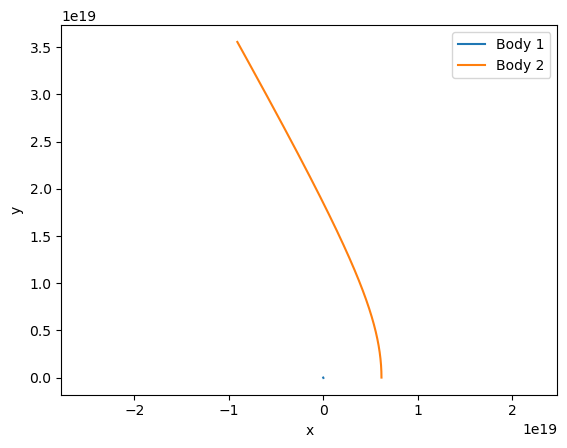

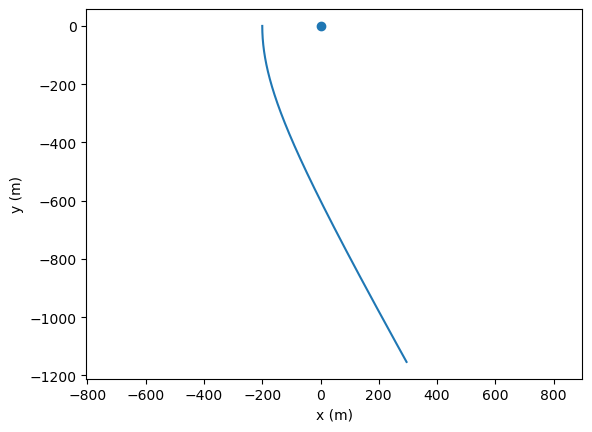

Data saved to particle_data.txt


In [7]:
# Example usage
m1 = 1e8*msun_kg
m2 = 1e5*msun_kg  # Moon mass in kg
semi_major_axis = 200*pc_m  # Earth-Moon distance in meters
eccentricity = 2.0  # Moon's orbit eccentricity
t_max =20*myr_s  # One year in seconds

init, two_body_solution = simulate_two_body(m1, m2, semi_major_axis, eccentricity, t_max=t_max,dt=t_max*1e-4)
plot_trajectory(two_body_solution)
plot_trajectory_reduced_mass(two_body_solution, m1, m2)
save_particle_data(two_body_solution, np.array([m1, m2]))



In [10]:
nbody = np.loadtxt("/mnt/home/yjo10/ceph/ENZO_NBODY/iso_plummer/core_enzo_1.dat")
halo = np.loadtxt("/mnt/home/yjo10/ceph/ENZO_NBODY/test_orbit_nbody/halo.dat_org")
nbody[:,0] -= init['r2'][0]/pc_m/1000   ## place NSC near the center of the simulation
nbody[:,4] += init['v2'][1]/1000
halo[0] -= init['r1'][0]/pc_m/1000   ## place NSC near the center of the simulation
halo[4] += init['v1'][1]/1000   ## place NSC near the center of the simulation
np.savetxt("/mnt/home/yjo10/ceph/ENZO_NBODY/test_orbit_nbody/nbody.dat_cir_2025.3.8", nbody)
np.savetxt("/mnt/home/yjo10/ceph/ENZO_NBODY/test_orbit_nbody/halo.dat_cir_2025.3.8", halo.reshape(1,-1))

In [31]:
init['r1']/pc_m

array([0.0999001, 0.       ])

In [22]:
init

{'r1': array([3.08291708e+15, 0.00000000e+00]),
 'r2': array([-3.08291708e+18,  0.00000000e+00]),
 'v1': array([  0.        , -65.55491427]),
 'v2': array([    0.        , 65554.91427216])}

## Example 2: Saving initional conditions for Abyss

### old

In [2]:
primary_mass = 5. # in msun
mass_ratios = np.array([1.0,0.8,0.5,0.3,0.1,0.01,0.001])
eccentricities = np.linspace(0,2,11)
semi_major_axes = np.array([0.1, 1, 10]) # in pc
epsilons = np.linspace(0,-3,11)
combinations = list(itertools.product(mass_ratios, eccentricities, semi_major_axes))

### new


In [10]:
primary_mass = 1. # in msun
#mass_ratios = np.array([1.0,0.8,0.5,0.2,0.1])
mass_ratios = np.array([1.0, 0.5,0.1])
eccentricities = np.linspace(0,2,6)
#semi_major_axes = np.array([0.1,0.5, 1, 2]) # in pc
semi_major_axes = np.array([0.1, 0.5, 1]) # in pc
epsilons = np.array([0.1, 0.01, 0.001])
combinations = list(itertools.product(mass_ratios, eccentricities, semi_major_axes))

In [30]:
len(combinations)

220

### generation

In [11]:
np.save("/mnt/home/yjo10/ceph/AITimeStepper/abyss/combinations_new.npy", combinations)
m1 = primary_mass
with open("/mnt/home/yjo10/ceph/AITimeStepper/abyss/combinations_new.txt", 'w') as g:
    for n, comb in enumerate(combinations):
        mratio = comb[0]
        e = comb[1]
        a = comb[2]
        m2 = m1*mratio
        init = two_body_initial_conditions(m1*msun_kg, m2*msun_kg, a*pc_m, e=e, G=6.67430e-11)
        if (e>=1):
            print(init)

        filename = f"/mnt/home/yjo10/ceph/AITimeStepper/abyss/ICs/two_body_{int(n+1)}_new.txt"
        with open(filename, 'w') as f:
            # Write particle data
            f.write(f"{init['r1'][0]*m_kpc} {init['r1'][1]*m_kpc} 0.0 {init['v1'][0]/1000} {init['v1'][1]/1000} 0.0 {m1/1e9}\n")
            f.write(f"{init['r2'][0]*m_kpc} {init['r2'][1]*m_kpc} 0.0 {init['v2'][0]/1000} {init['v2'][1]/1000} 0.0 {m2/1e9}\n")


        mu = 6.67430e-11 * (m1 + m2) *msun_kg
        stoptime = orbital_period(a*pc_m, mu, e)
        if stoptime is np.nan or stoptime is np.inf:
            stoptime = 66279131 
        else:
            stoptime /= yr_s
        print(stoptime)
            
        for m, eps in enumerate(epsilons):
            filename = f"/mnt/home/yjo10/ceph/AITimeStepper/abyss/configs/two_body_{int(n+1)}_{int(m+1)}_new.txt"
            with open(filename, 'w') as f:
                # Write particle data
                f.write(f"Filename  = ICs/two_body_{int(n+1)}_new.txt\n")
                f.write(f"eta       = {eps}\n")
                f.write(f"InitialRadius = 0\n")
                f.write(f"FixNumNeighbor = 0\n")
                f.write(f"StopTime  = {stoptime}\n")
                f.write(f"dtOutput  = {stoptime/100}\n")
                f.write(f"OutputDirectory  = two_body_{int(n+1)}_{int(m+1)}_new\n")


        g.write(f" Combination {int(n+1)}  \n")
        g.write(f"*******************************\n")
        g.write(f" Primary Mass    = {m1} Msun \n")
        g.write(f" Secondary Mass  = {m2} Msun \n")
        g.write(f" Semi-major Axis = {a} pc    \n")
        g.write(f" Eccentricity    = {e:.1f}       \n")
        g.write(f"*******************************\n\n")

    g.write(f"** Epsilon values range from 1 to 0.001 in 11 steps.\n")


2095930.177468392
23433211.76456261
66279131.77481043
2095930.177468392
23433211.76456261
66279131.77481043
2095930.177468392
23433211.76456261
66279131.77481043
{'r1': array([-3.086e+14,  0.000e+00]), 'r2': array([3.086e+14, 0.000e+00]), 'v1': array([   0.        , -486.41127943]), 'v2': array([  0.        , 486.41127943])}
66279131
{'r1': array([-1.543e+15,  0.000e+00]), 'r2': array([1.543e+15, 0.000e+00]), 'v1': array([   0.        , -217.52973717]), 'v2': array([  0.        , 217.52973717])}
66279131
{'r1': array([-3.086e+15,  0.000e+00]), 'r2': array([3.086e+15, 0.000e+00]), 'v1': array([   0.        , -153.81675226]), 'v2': array([  0.        , 153.81675226])}
66279131
{'r1': array([-9.258e+14,  0.000e+00]), 'r2': array([9.258e+14, 0.000e+00]), 'v1': array([   0.        , -305.29405228]), 'v2': array([  0.        , 305.29405228])}
66279131
{'r1': array([-4.629e+15,  0.000e+00]), 'r2': array([4.629e+15, 0.000e+00]), 'v1': array([   0.        , -136.53165081]), 'v2': array([  0.   

### writing a job script

In [12]:
with open("/mnt/home/yjo10/ceph/AITimeStepper/abyss/run_extenstive.sh", 'w') as g:
    g.write("#!/bin/bash\n")
    g.write("#SBATCH --job-name=ATs\n")
    g.write("#SBATCH --mail-type=ALL\n")
    g.write("#SBATCH --mail-user=g.kerex@gmail.com\n")
    g.write("#SBATCH --time=120:00:00\n")
    g.write("#SBATCH -N 1\n")
    g.write("#SBATCH -p cca\n")
    g.write("#SBATCH --ntasks-per-node=2\n")
    g.write("#SBATCH -p gpu --gpus=1 -C a100\n\n")
    g.write("module add modules/2.3-20240529\n")
    g.write("module add cuda\n")
    g.write("module add openmpi\n\n")
    for n, comb in enumerate(combinations):
        for m, eps in enumerate(epsilons):
            config_file = f"configs/two_body_{int(n+1)}_{int(m+1)}_new.txt"
            g.write(f"mpirun ./abyss-stable.exe -c {config_file} > stdout 2> stderr\n")

## Example 3: Calculating orbital period

Orbital period: inf seconds ( inf years)


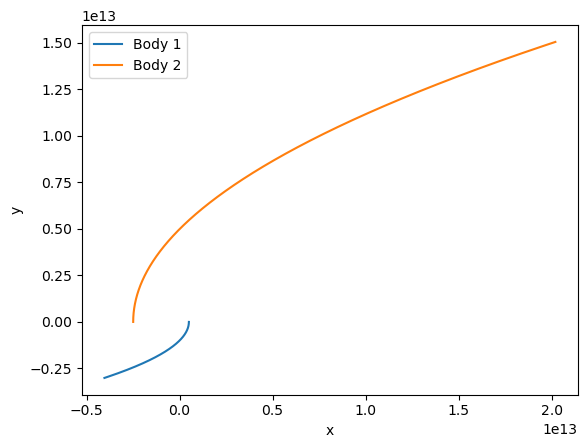

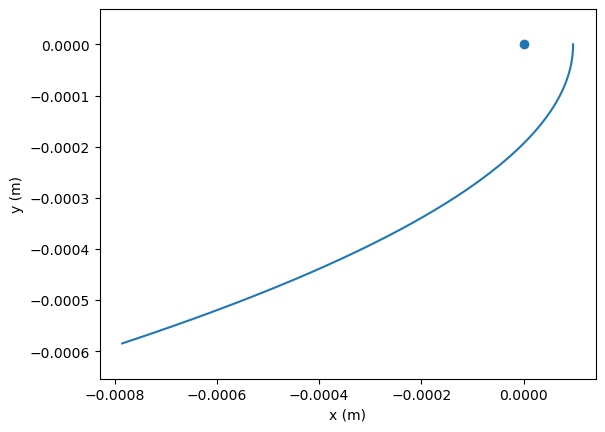

Data saved to particle_data.txt


In [65]:
# Example usage
m1 = 5*msun_kg
m2 = 1*msun_kg  # Moon mass in kg
semi_major_axis = 10*au_m  # Earth-Moon distance in meters
eccentricity = 1.0  # Moon's orbit eccentricity
mu = 6.67430e-11 * (m1 + m2)
period = orbital_period(semi_major_axis, mu, eccentricity)
print(f'Orbital period: {period:.2f} seconds ( {period/yr_s:.2f} years)')
t_max =100.*yr_s  # One year in seconds
#t_max = period

init, two_body_solution = simulate_two_body(m1, m2, semi_major_axis, eccentricity, t_max=t_max,dt=t_max*1e-4)
plot_trajectory(two_body_solution)
plot_trajectory_reduced_mass(two_body_solution, m1, m2)
save_particle_data(two_body_solution, np.array([m1, m2]))



In [ ]:
nbody = np.loadtxt("/mnt/home/yjo10/ceph/ENZO_NBODY/iso_plummer/core_enzo_1.dat")
halo = np.loadtxt("/mnt/home/yjo10/ceph/ENZO_NBODY/test_orbit_nbody/halo.dat_org")
nbody[:,0] -= init['r2'][0]/pc_m/1000   ## place NSC near the center of the simulation
nbody[:,4] += init['v2'][1]/1000
halo[0] -= init['r1'][0]/pc_m/1000   ## place NSC near the center of the simulation
halo[4] += init['v1'][1]/1000   ## place NSC near the center of the simulation
np.savetxt("/mnt/home/yjo10/ceph/ENZO_NBODY/test_orbit_nbody/nbody.dat_cir_2025.3.8", nbody)
np.savetxt("/mnt/home/yjo10/ceph/ENZO_NBODY/test_orbit_nbody/halo.dat_cir_2025.3.8", halo.reshape(1,-1))

In [ ]:
init['r1']/pc_m

array([0.0999001, 0.       ])

In [ ]:
init

{'r1': array([3.08291708e+15, 0.00000000e+00]),
 'r2': array([-3.08291708e+18,  0.00000000e+00]),
 'v1': array([  0.        , -65.55491427]),
 'v2': array([    0.        , 65554.91427216])}

## Example 4 : Random

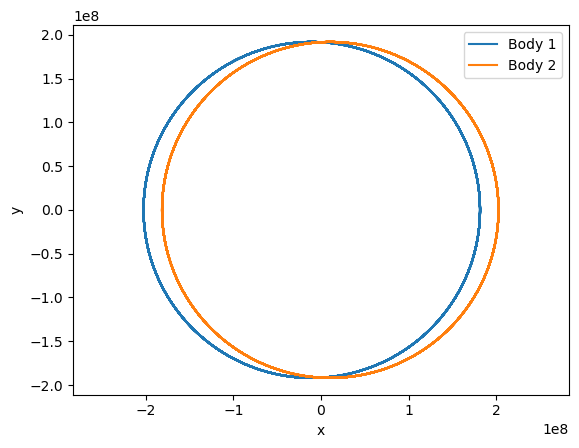

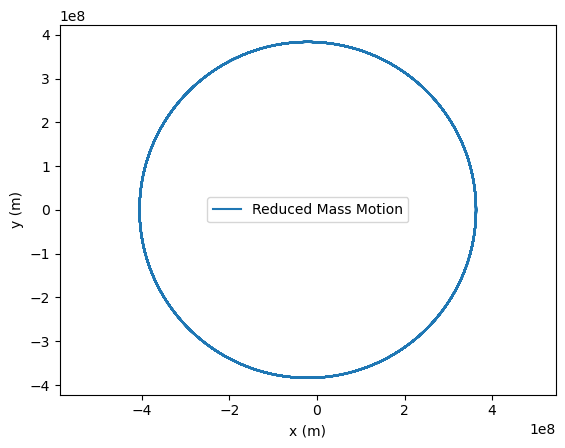

In [6]:
# Example usage
m1 = 5.972e24  # Earth mass in kg
m2 = 5.972e24  # Earth mass in kg
semi_major_axis = 3.844e8  # Earth-Moon distance in meters
eccentricity = 0.0549  # Moon's orbit eccentricity
t_max = 3.154e7  # One year in seconds

two_body_solution = simulate_two_body(m1, m2, semi_major_axis, eccentricity, t_max=t_max)
plot_trajectory(two_body_solution)
plot_trajectory_reduced_mass(two_body_solution, m1, m2)


## EXAMPLE FOR ORBIT TEST

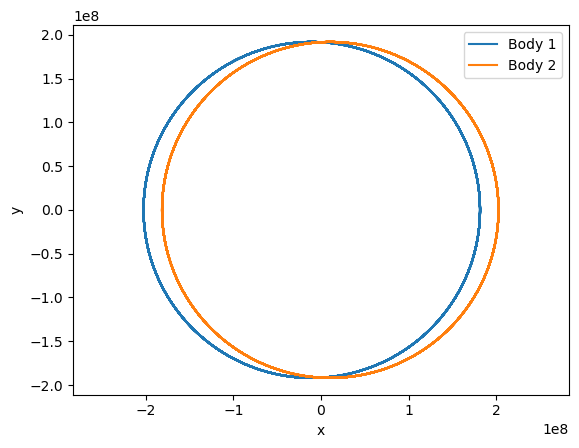

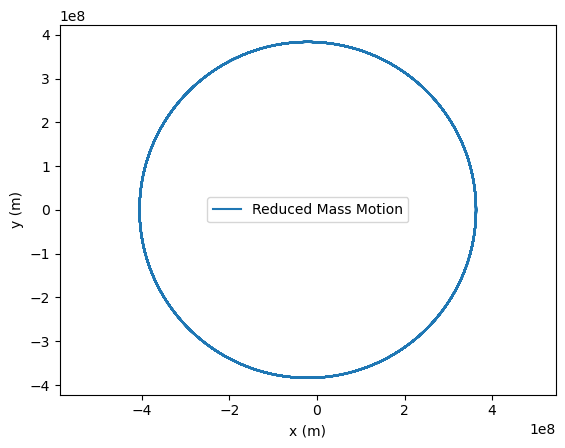

In [ ]:
# Example usage
m1 = 5.972e24  # Earth mass in kg
m2 = 5.972e24  # Earth mass in kg
semi_major_axis = 3.844e8  # Earth-Moon distance in meters
eccentricity = 0.0549  # Moon's orbit eccentricity
t_max = 3.154e7  # One year in seconds

two_body_solution = simulate_two_body(m1, m2, semi_major_axis, eccentricity, t_max=t_max)
plot_trajectory(two_body_solution)
plot_trajectory_reduced_mass(two_body_solution, m1, m2)


# THREE BODY

In [2]:
import numpy as np

def generate_three_body_ic(mode='random', num_samples=1, total_mass=1.0, pos_scale=1.0, vel_scale=1.0, random_seed=None):
    """
    Generate initial conditions for a three-body gravitational problem in physical units.

    The units used are:
        - Masses in solar masses (Msun)
        - Positions in kiloparsecs (kpc)
        - Velocities in kilometers per second (km/s)

    Note:
        When using these physical units, the gravitational constant is:
            G ≈ 4.3009e-6 kpc (km/s)^2 / Msun

    Parameters:
        mode (str): 'random' for randomly generated ICs or 'figure8' for the classic figure-8 solution.
        num_samples (int): Number of random samples to generate (ignored for figure8 mode).
        total_mass (float): Total mass of the system in Msun.
        pos_scale (float): Spatial scale (kpc) for random positions.
        vel_scale (float): Velocity scale (km/s) for random velocities.
        random_seed (int): Seed for reproducibility in random mode.

    Returns:
        List of dictionaries containing masses, positions, and velocities.
        - 'masses': 1D numpy array of length 3 (in Msun).
        - 'positions': 3x3 numpy array (each row is [x, y, z] in kpc).
        - 'velocities': 3x3 numpy array (each row is [vx, vy, vz] in km/s).
    """
    if mode == 'random':
        if random_seed is not None:
            np.random.seed(random_seed)
        ic_list = []
        for i in range(num_samples):
            # Generate random masses and normalize to total_mass (Msun)
            masses = np.random.random(3)
            masses = masses / np.sum(masses) * total_mass
            
            # Generate random positions in a cube [-pos_scale, pos_scale] kpc.
            positions = np.random.uniform(-pos_scale, pos_scale, (3, 3))
            # Generate random velocities in a cube [-vel_scale, vel_scale] km/s.
            velocities = np.random.uniform(-vel_scale, vel_scale, (3, 3))
            
            # Adjust positions so that the center of mass is at the origin.
            com_position = np.sum(masses[:, None] * positions, axis=0) / total_mass
            positions -= com_position
            
            # Adjust velocities so that the total momentum is zero.
            total_momentum = np.sum(masses[:, None] * velocities, axis=0)
            com_velocity = total_momentum / total_mass
            velocities -= com_velocity
            
            ic_list.append({
                'masses': masses,
                'positions': positions,
                'velocities': velocities
            })
        return ic_list
    
    elif mode == 'figure8':
        # Figure-8 solution for equal masses (each mass = total_mass/3).
        masses = np.array([total_mass/3, total_mass/3, total_mass/3])
        
        # Figure-8 positions and velocities (2D; z=0) from the literature.
        # These are the dimensionless values scaled by pos_scale and vel_scale.
        positions = np.array([[ 0.97000436, -0.24308753, 0.0],
                              [-0.97000436,  0.24308753, 0.0],
                              [ 0.0,         0.0,        0.0]]) * pos_scale
        
        velocities = np.array([[ 0.4662036850,  0.4323657300, 0.0],
                               [ 0.4662036850,  0.4323657300, 0.0],
                               [-0.93240737,   -0.86473146,  0.0]]) * vel_scale
        
        # Adjust to ensure the center of mass and net momentum are zero.
        com_position = np.sum(masses[:, None] * positions, axis=0) / total_mass
        positions -= com_position
        total_momentum = np.sum(masses[:, None] * velocities, axis=0)
        com_velocity = total_momentum / total_mass
        velocities -= com_velocity
        
        return [{
            'masses': masses,
            'positions': positions,
            'velocities': velocities
        }]
    
    else:
        raise ValueError("Mode not recognized. Choose 'random' or 'figure8'.")


## Little Test

In [4]:
# Example: Generate one random initial condition in physical units.
random_ic = generate_three_body_ic(mode='random', num_samples=1, total_mass=1.0e6, pos_scale=1.0, vel_scale=100.0, random_seed=42)
print("Random Initial Condition (Physical Units):")
for entry in random_ic:
    print("Masses (Msun):", entry['masses'])
    print("Positions (kpc):\n", entry['positions'])
    print("Velocities (km/s):\n", entry['velocities'])

# Example: Generate the figure-8 initial condition in physical units.
figure8_ic = generate_three_body_ic(mode='figure8', total_mass=1.0e6, pos_scale=1.0, vel_scale=100.0)
print("\nFigure-8 Initial Condition (Physical Units):")
for entry in figure8_ic:
    print("Masses (Msun):", entry['masses'])
    print("Positions (kpc):\n", entry['positions'])
    print("Velocities (km/s):\n", entry['velocities'])

Random Initial Condition (Physical Units):
Masses (Msun): [182058.7756164  462129.08544658 355812.13893702]
Positions (kpc):
 [[ 0.42176902 -0.55999065 -0.99060816]
 [-0.65938073  0.86032436 -0.10036718]
 [ 0.6405972  -0.83085894  0.6372225 ]]
Velocities (km/s):
 [[ 88.48826269 -14.10822812 -62.29755214]
 [-41.3193635    4.27239833   6.28874074]
 [  8.38873826   1.66977778  23.70803336]]

Figure-8 Initial Condition (Physical Units):
Masses (Msun): [333333.33333333 333333.33333333 333333.33333333]
Positions (kpc):
 [[ 0.97000436 -0.24308753  0.        ]
 [-0.97000436  0.24308753  0.        ]
 [ 0.          0.          0.        ]]
Velocities (km/s):
 [[ 46.6203685  43.236573    0.       ]
 [ 46.6203685  43.236573    0.       ]
 [-93.240737  -86.473146    0.       ]]


In [16]:
np.sum(random_ic[0]['masses'][:,None]*random_ic[0]['positions'],axis=0)

array([-5.82076609e-11,  5.82076609e-11, -2.91038305e-11])

In [18]:
random_ic[0]["masses"].shape

(3,)

## Output file for Abyss

In [35]:
epsilons = np.linspace(1,-3,6)
num_samples = 100
random_ic = generate_three_body_ic(mode='random', num_samples=num_samples, total_mass=1.0e4, pos_scale=0.001, vel_scale=1.0, random_seed=42) ## kpc, msun, km/s scales
for n in range(num_samples):
    init = random_ic[n]
    filename = f"/mnt/home/yjo10/ceph/AITimeStepper/abyss/ICs/three_body_{int(n+1)}.txt"
    with open(filename, 'w') as f:
        # Write particle data
        for i in range(3):
            f.write(f"{init['positions'][i,0]} {init['positions'][i,1]} {init['positions'][i,2]} {init['velocities'][i,0]} {init['velocities'][i,1]} {init['velocities'][i,2]} {init['masses'][i]/1e9}\n")
        
    stoptime = 1e6 # in yrs

        
    for m, eps in enumerate(epsilons):
        filename = f"/mnt/home/yjo10/ceph/AITimeStepper/abyss/configs/three_body_{int(n+1)}_{int(m+1)}.txt"
        with open(filename, 'w') as f:
            # Write particle data
            f.write(f"Filename  = ICs/three_body_{int(n+1)}.txt\n")
            f.write(f"eta       = {10**eps}\n")
            f.write(f"InitialRadius = 0\n")
            f.write(f"FixNumNeighbor = 0\n")
            f.write(f"StopTime  = {stoptime}\n")
            f.write(f"dtOutput  = {stoptime/100}\n")
            f.write(f"OutputDirectory  = three_body_{int(n+1)}_{int(m+1)}\n")


In [36]:
with open("/mnt/home/yjo10/ceph/AITimeStepper/abyss/run_three_body.sh", 'w') as g:
    g.write("#!/bin/bash\n")
    g.write("#SBATCH --job-name=ATs\n")
    g.write("#SBATCH --mail-type=ALL\n")
    g.write("#SBATCH --mail-user=g.kerex@gmail.com\n")
    g.write("#SBATCH --time=120:00:00\n")
    g.write("#SBATCH -N 1\n")
    g.write("#SBATCH -p cca\n")
    g.write("#SBATCH --ntasks-per-node=2\n")
    g.write("#SBATCH -p gpu --gpus=1 -C a100\n\n")
    g.write("module add modules/2.3-20240529\n")
    g.write("module add cuda\n")
    g.write("module add openmpi\n\n")
    for n in range(num_samples):
        for m, _ in enumerate(epsilons):
            config_file = f"configs/three_body_{int(n+1)}_{int(m+1)}.txt"
            g.write(f"mpirun ./abyss-stable.exe -c {config_file} > stdout 2> stderr\n")